In [1]:
from dichasus_cf0x import test_set, spec
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm.auto import tqdm

2024-02-10 16:55:45.599489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 16:55:46.303937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-10 16:55:47.307931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:55:47.332750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
test_set_positions = np.load("results/test_set_positions.npy")
test_set_csi_gan_randomnoise = np.load("results/test_set_csi_gan_randomnoise.npy")
test_set_csi_gan_fixednoise = np.load("results/test_set_csi_gan_fixednoise.npy")
test_set_csi_interpolated = np.load("results/test_set_csi_interpolated.npy")
test_set_csi_interpolated_valid = np.load("results/test_set_csi_interpolated_valid.npy")

In [3]:
# Use "training set" CSI to predict CSI at test set positions
test_set_csi_cplx = []

with tqdm(total = len(test_set_positions)) as pbar:
    for csi, pos, time, ds in test_set.batch(100):
        test_set_csi_cplx.append(csi.numpy())
        pbar.update(tf.shape(csi)[0].numpy())

test_set_csi_cplx = np.concatenate(test_set_csi_cplx)

  0%|          | 0/20973 [00:00<?, ?it/s]

In [4]:
test_set_csi = np.stack([np.real(test_set_csi_cplx), np.imag(test_set_csi_cplx)], axis = -1)

In [5]:
def compute_delayspread(csi):
    powers = tf.square(csi[...,0]) + tf.square(csi[...,1])
    timestamps = tf.range(tf.shape(csi)[4], dtype = np.float32) / spec["bandwidth"]
    time_weighted_powers = tf.einsum("darmt,t->darmt", powers, timestamps)
    mean_delays = tf.divide(tf.reduce_sum(time_weighted_powers, axis = 4), tf.reduce_sum(powers, axis = 4))
    squared_delays = tf.square(timestamps[tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis, :] - mean_delays[..., tf.newaxis])
    delayspreads = tf.sqrt(tf.divide(tf.reduce_sum(tf.multiply(squared_delays, powers), axis = 4), tf.reduce_sum(powers, axis = 4)))

    return delayspreads

In [6]:
def plot_delayspread(title, positions, generated_csi, valid = None):
    generated_ds = compute_delayspread(generated_csi)

    if valid is None:
        valid = np.arange(len(generated_csi))
    else:
        valid = np.argwhere(valid).flatten()
    
    for ant in range(tf.shape(generated_ds)[1].numpy()):
        plt.figure(figsize=(7, 7))
        plt.title(title + ": Delay Spread - Antenna " + str(ant))
        plt.hexbin(positions[valid,0], positions[valid,1], C = tf.reduce_mean(tf.gather(generated_ds, valid)[:,ant], axis = (1, 2)), gridsize = 40, vmin = 0, vmax = 1.5e-7)
        plt.xlabel("Transmitter Position x [m]")
        plt.ylabel("Transmitter Position y [m]")
        plt.xlim((-12.5, 2.5))
        plt.ylim((-15.5, -0.5))
        plt.colorbar(label = "Delay Spread [s]")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.title(title + ": Delay Spread Histogram - Antenna " + str(ant))
        plt.xlabel("Delay Spread")
        plt.ylabel("Occurences")
        plt.hist(tf.gather(generated_ds, valid)[:,ant].numpy().flatten(), bins = 50, range = (0, 2e-7))
        plt.show()

### Generate Plots

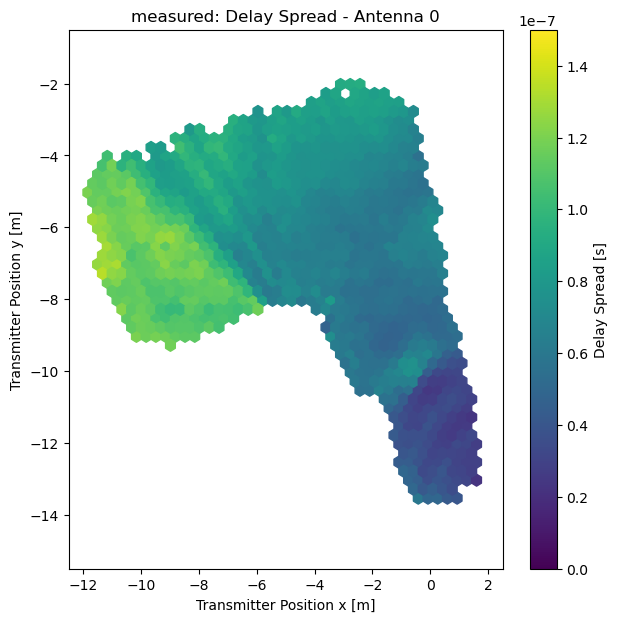

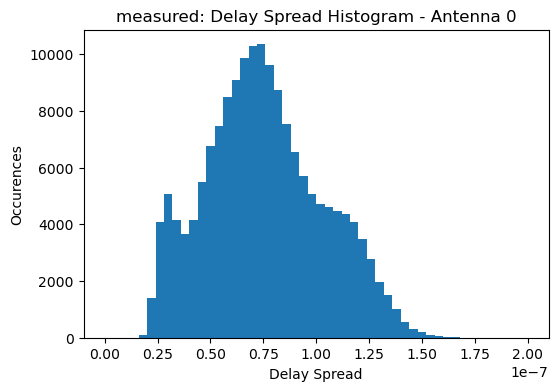

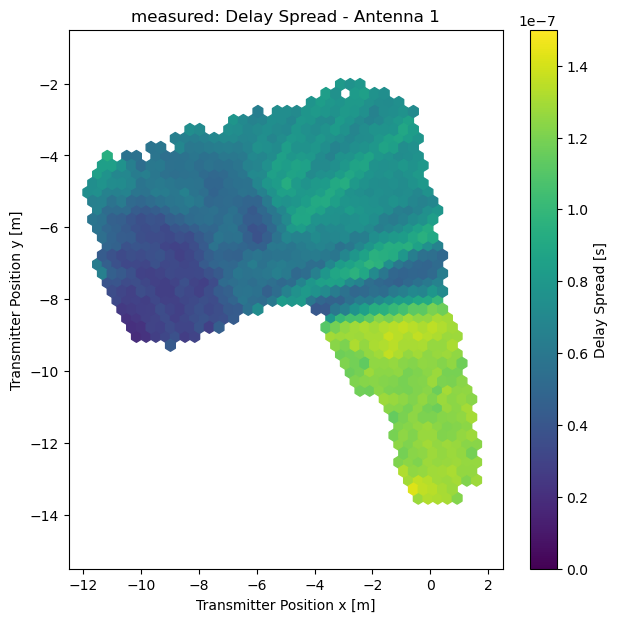

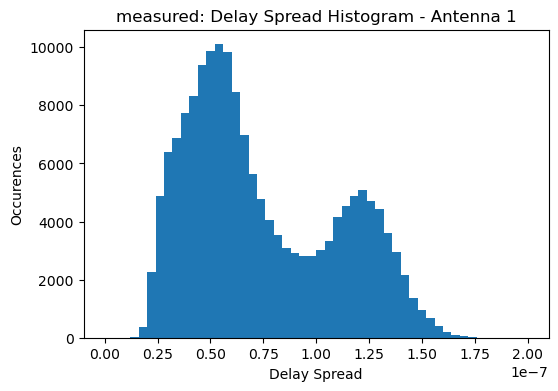

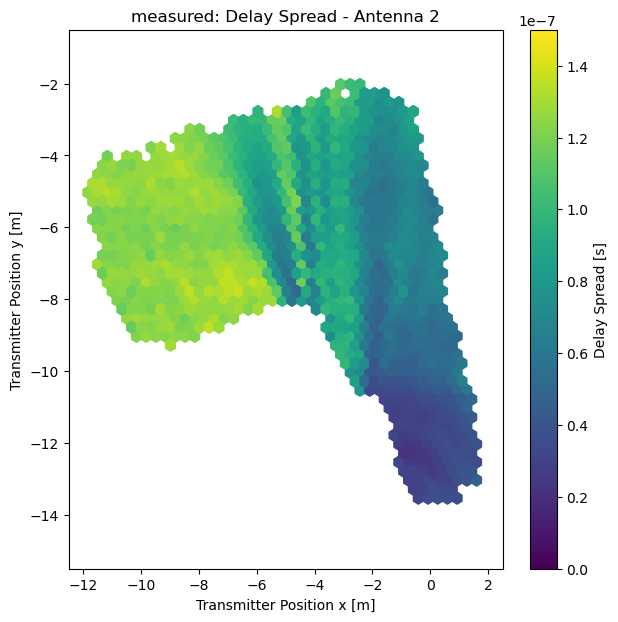

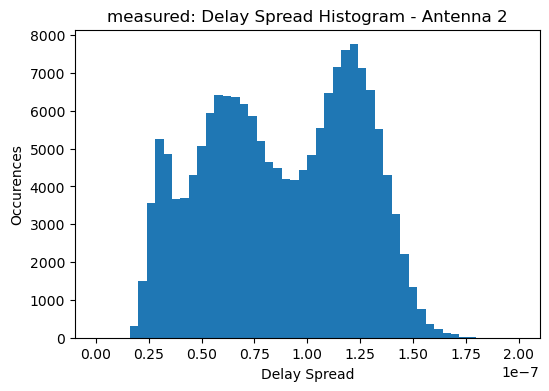

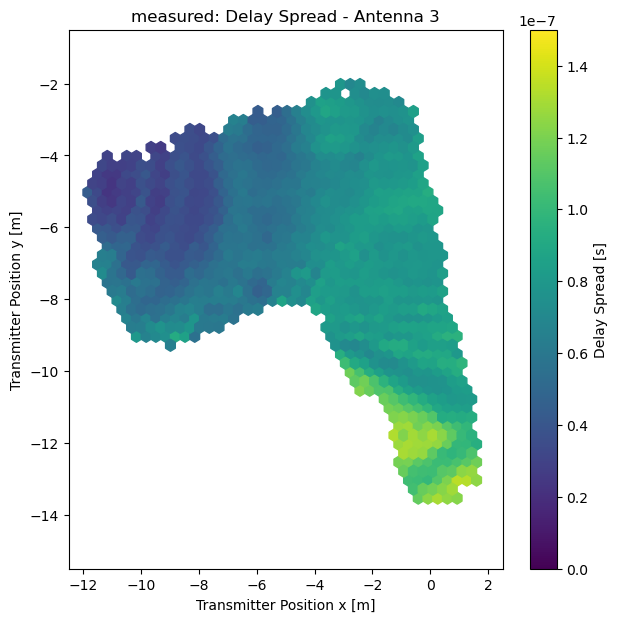

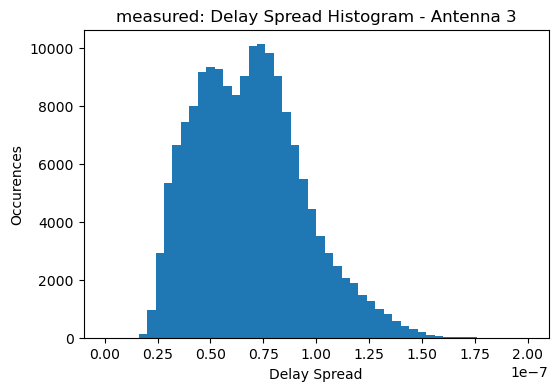

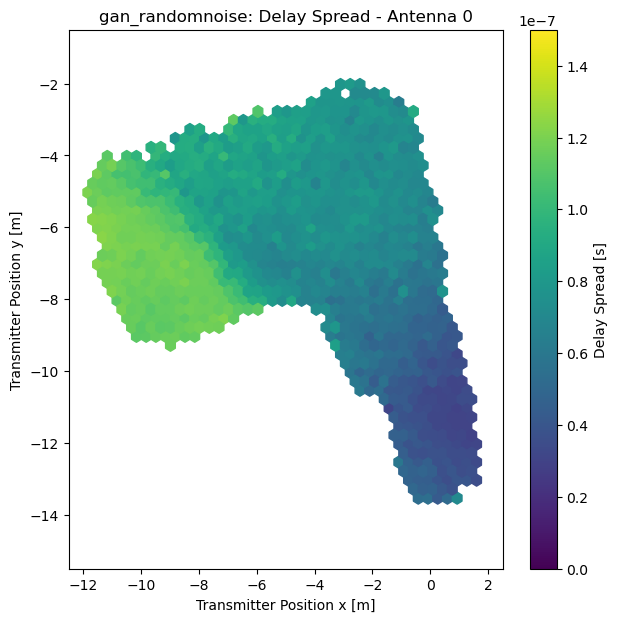

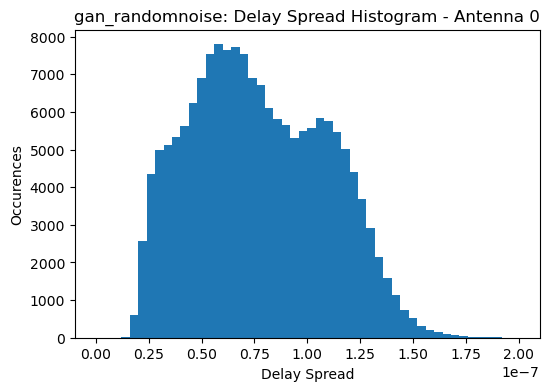

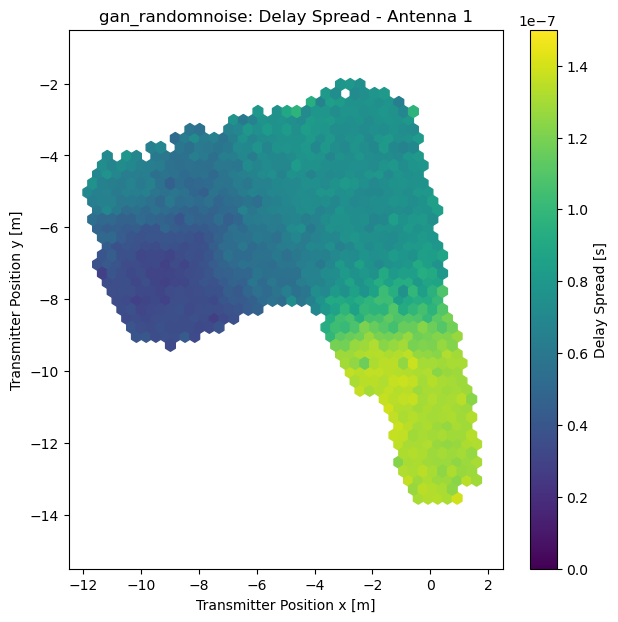

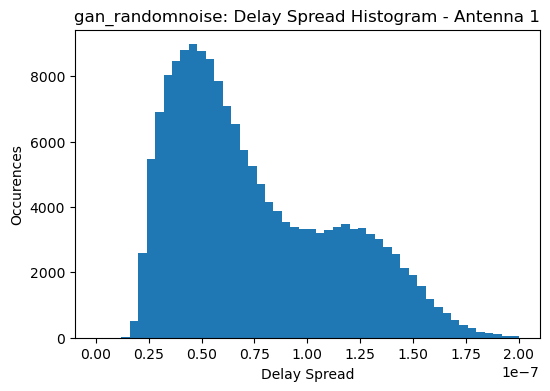

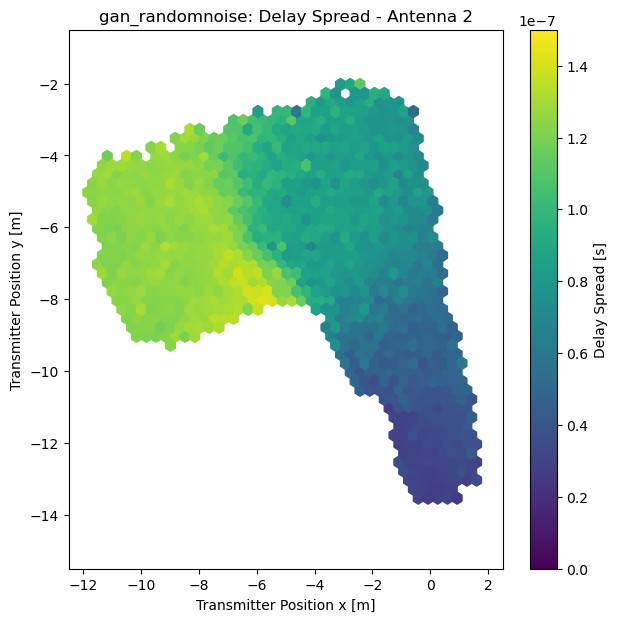

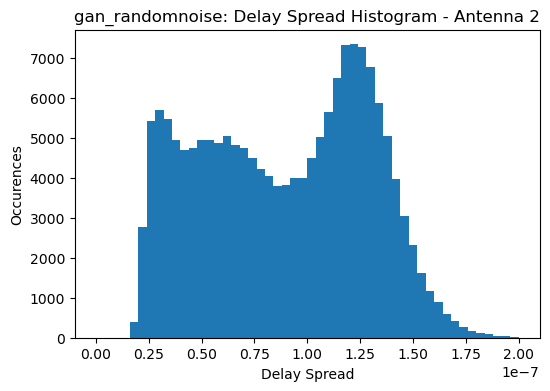

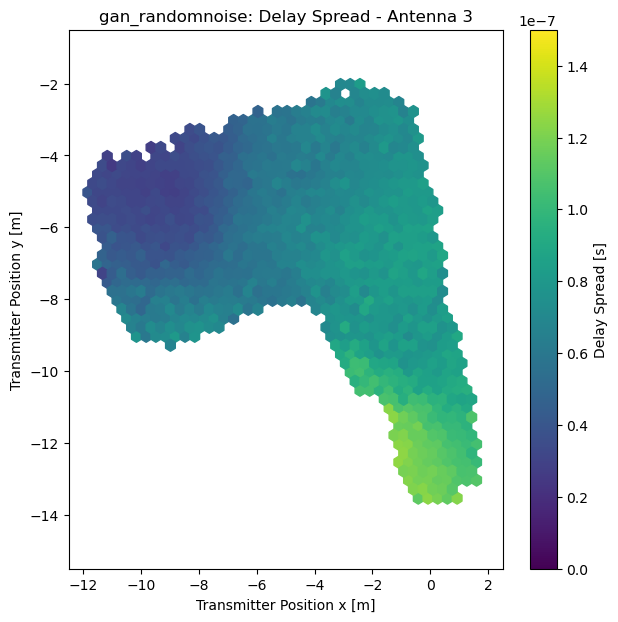

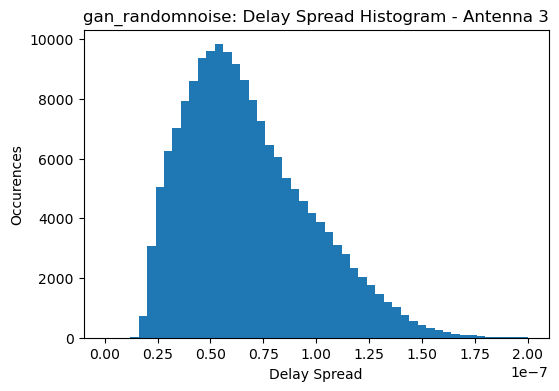

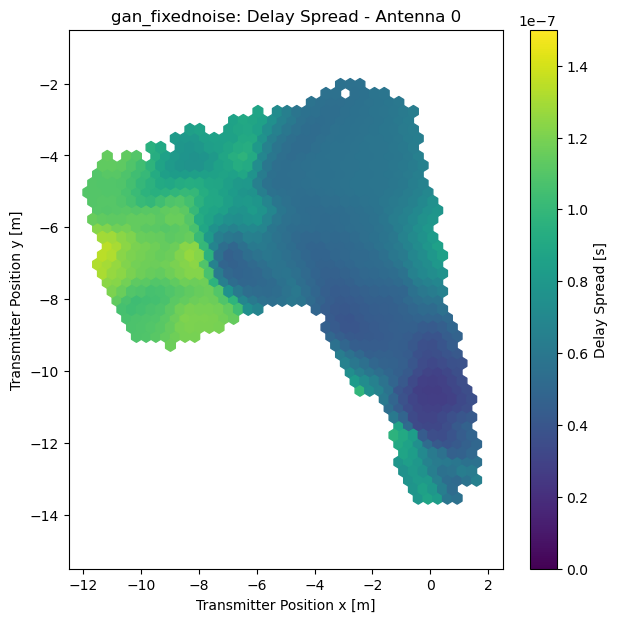

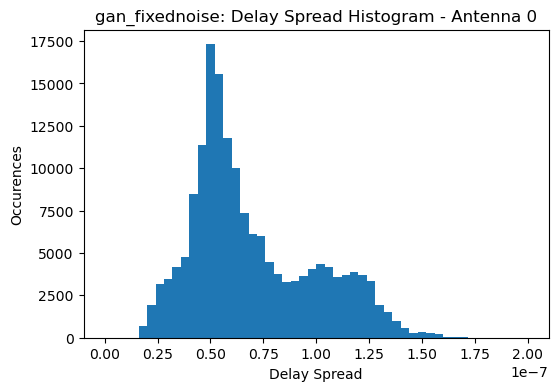

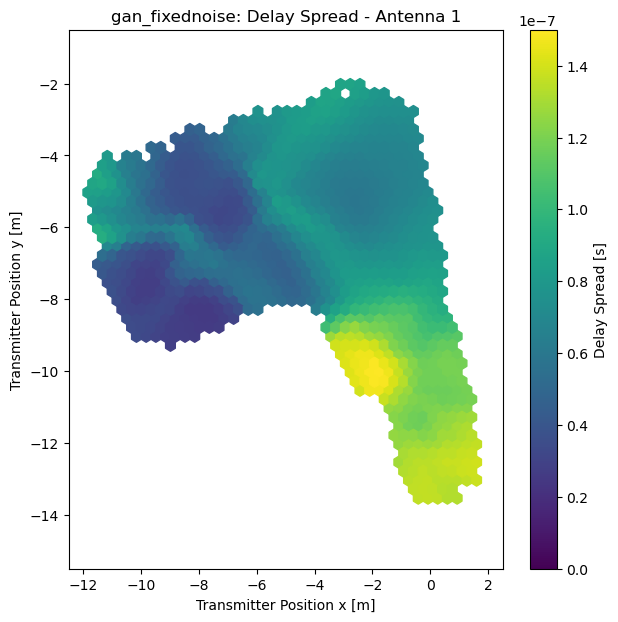

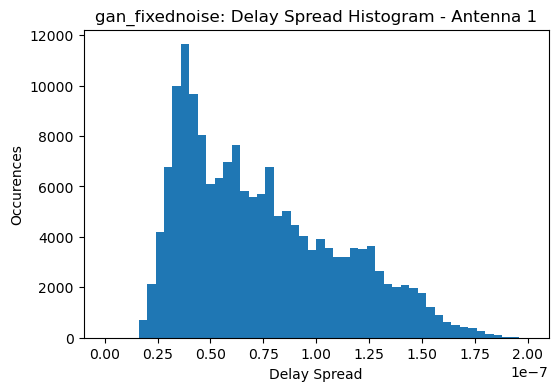

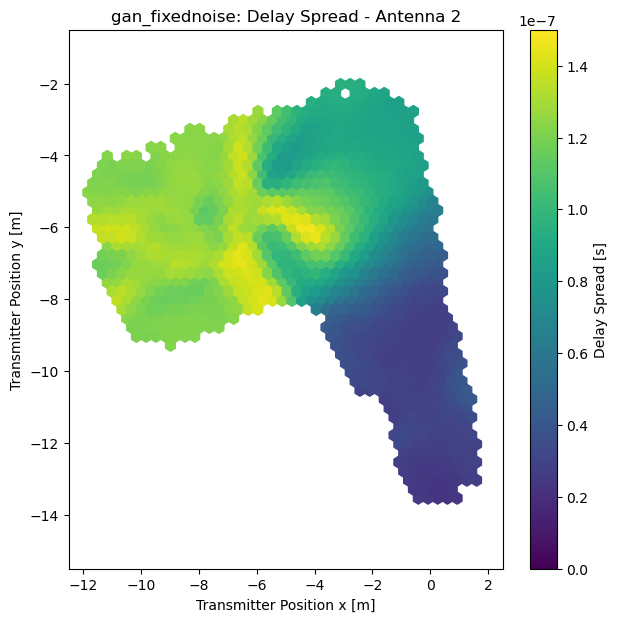

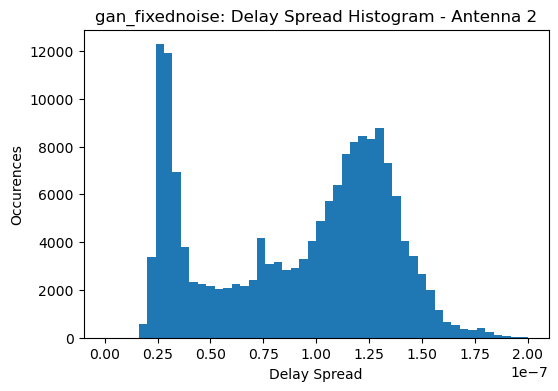

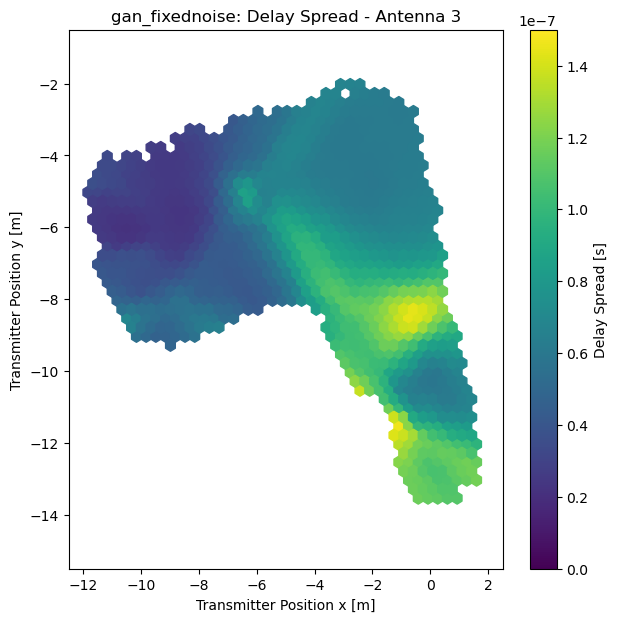

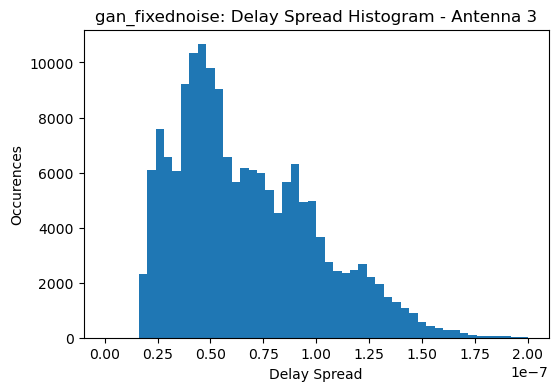

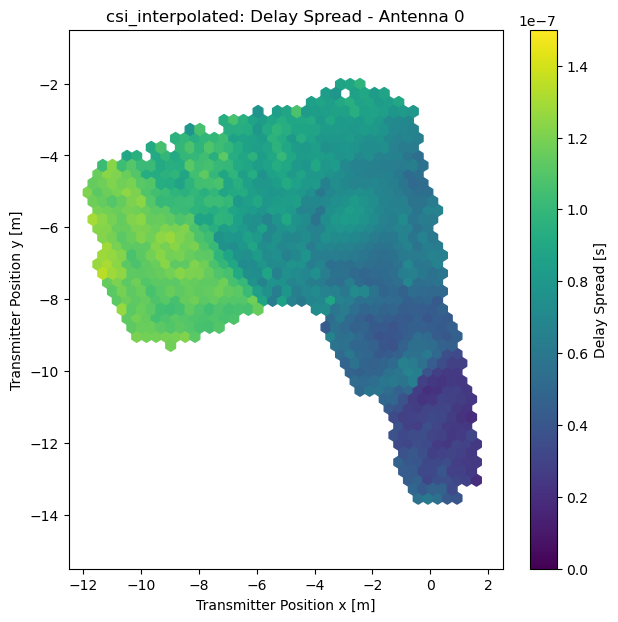

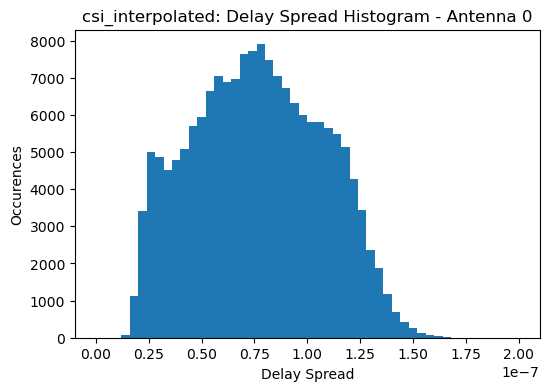

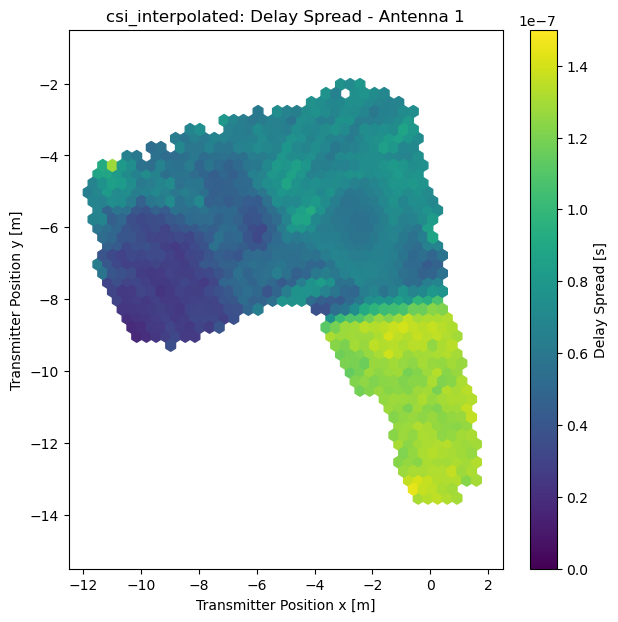

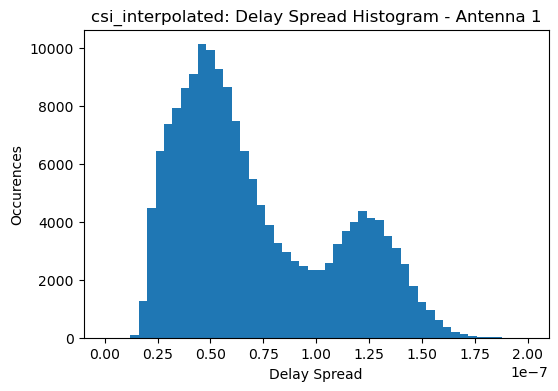

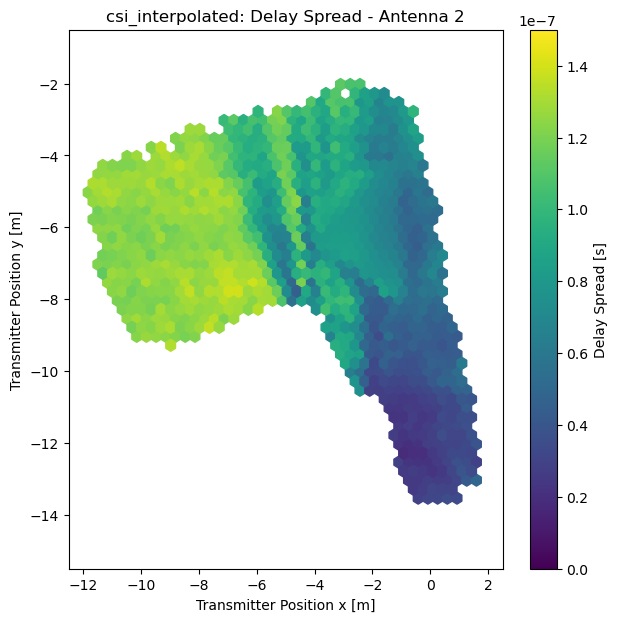

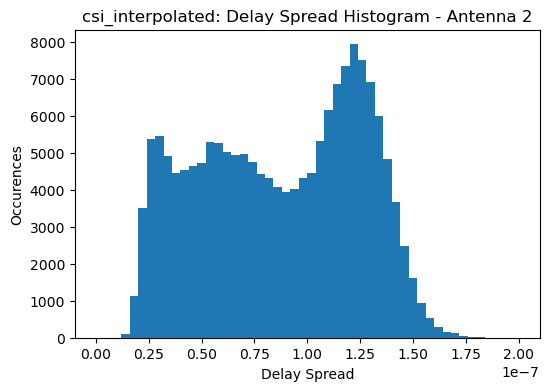

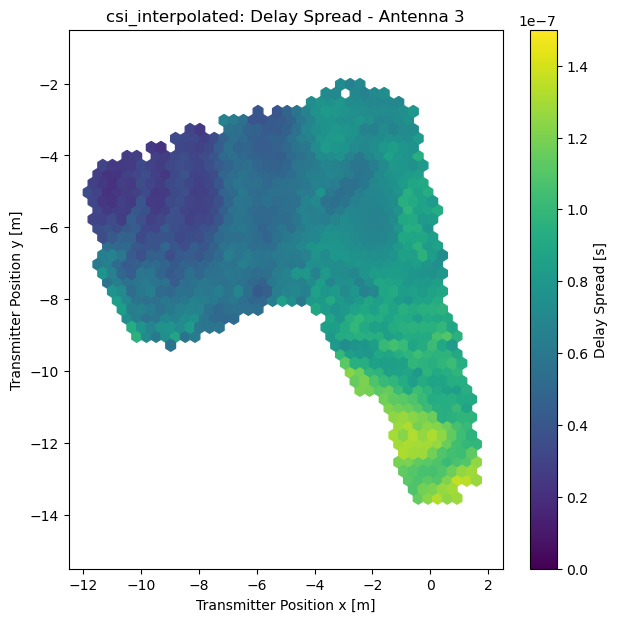

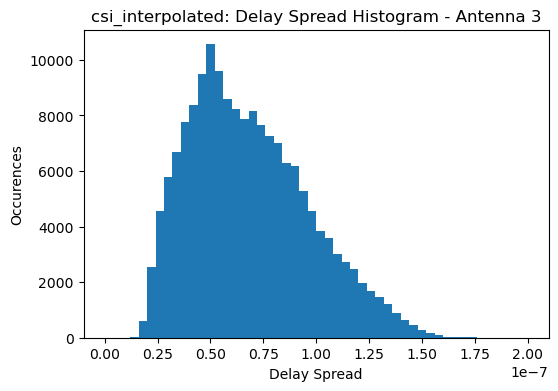

In [7]:
plot_delayspread("measured", test_set_positions, test_set_csi)
plot_delayspread("gan_randomnoise", test_set_positions, test_set_csi_gan_randomnoise)
plot_delayspread("gan_fixednoise", test_set_positions, test_set_csi_gan_fixednoise)
plot_delayspread("csi_interpolated", test_set_positions, test_set_csi_interpolated, test_set_csi_interpolated_valid)